In [ ]:
pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [1]:
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data as D
from torchvision import transforms as T

from segmentation_models_pytorch.unetplusplus import UnetPlusPlus
import segmentation_models_pytorch as smp

import albumentations as A

from pathlib import Path
import re
import glob

from sklearn.model_selection import GroupKFold

In [4]:
orig = 1024
sz = 512 #128 #256 #the size of tiles
reduce = orig//sz  #reduce the original images by 'reduce' times 
MASKS = Path('data/train.csv')
DATA = Path('data/train/')
s_th = 40  # saturation blancking threshold
p_th = 200*sz//256 #threshold for the minimum number of pixels

assert MASKS.exists()
assert DATA.exists()

In [5]:
df_masks = pd.read_csv(MASKS).set_index('id')
df_masks.head()

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...

In [6]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        s = enc.split()
        id = 1 + m
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = id # the number 
    return img.reshape(shape).T

In [7]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [8]:
train_path = Path('image_cache')
assert train_path.exists()

In [9]:
def serialize_example(index, cnt, image, mask):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    cv2.imwrite(str(train_path/f"img_{index}_{cnt}.png"), image)
    cv2.imwrite(str(train_path/f"mask_{index}_{cnt}.png"), mask)

Execute to re-create the image folder

In [10]:
!rm -rf {train_path}
os.makedirs(train_path)

In [11]:
%%time

x_tot,x2_tot = [],[]

translation_matrices = [ None, np.float32([[1, 0, orig // 2],  [0, 1, 0] ]) ]
# translation_matrices = [ None ]

cnt = 0
for i, translation_matrix in enumerate(translation_matrices):
    for index, encs in tqdm(df_masks.iterrows(), total=len(df_masks)):
        #read image and generate the mask
        img = tiff.imread(os.path.join(DATA, index+'.tiff'))
        if len(img.shape) == 5:
#             img = np.transpose(img.squeeze(), (1,2,0))
            img = np.moveaxis(img.squeeze(), 0, -1)
        mask = enc2mask(encs, (img.shape[1],img.shape[0]))

        shape = img.shape

        reduce_size_prod = reduce*sz
        assert reduce_size_prod == orig, "reduce_size_prod is not original size"
        pad0 = (reduce_size_prod - shape[0]%(reduce_size_prod))%(reduce_size_prod)
        pad1 = (reduce_size_prod - shape[1]%(reduce_size_prod))%(reduce_size_prod)
        print(shape, pad0, pad1)
        img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                    constant_values=0)
        mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2]],
                    constant_values=0)

        print('Shape comparison', shape, img.shape)
        print(shape, mask.shape)

        #split image and mask into tiles using the reshape+transpose trick
        img = cv2.resize(img,(img.shape[1]//reduce,img.shape[0]//reduce),
                         interpolation = cv2.INTER_AREA)

        # apply transformation for generate more images
        if translation_matrix is not None:
            img = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))

        img = img.reshape(img.shape[0]//sz, sz, img.shape[1]//sz, sz, 3)
        img = img.transpose(0,2,1,3,4).reshape(-1, sz, sz, 3)
        print('after reshape transpose', img.shape)

        mask = cv2.resize(mask,(mask.shape[1]//reduce,mask.shape[0]//reduce),
                          interpolation = cv2.INTER_NEAREST)

        # apply transformation for generate more images
        if translation_matrix is not None:
            mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

        mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz)
        mask = mask.transpose(0,2,1,3).reshape(-1,sz,sz)
        print('mask after reshape transpose', img.shape)

        for i,(im,m) in enumerate(zip(img,mask)):
            #remove black or gray images based on saturation check
            hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            if not ((s>s_th).sum() <= p_th or im.sum() <= p_th):

                x_tot.append((im/255.0).reshape(-1,3).mean(0))
                x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))

                im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
                example = serialize_example(index, cnt, im, m)

                cnt += 1
        

  0%|          | 0/8 [00:00<?, ?it/s]

(31278, 25794, 3) 466 830
Shape comparison (31278, 25794, 3) (31744, 26624, 3)
(31278, 25794, 3) (31744, 26624)
after reshape transpose (806, 512, 512, 3)
mask after reshape transpose (806, 512, 512, 3)
(18484, 13013, 3) 972 299
Shape comparison (18484, 13013, 3) (19456, 13312, 3)
(18484, 13013, 3) (19456, 13312)
after reshape transpose (247, 512, 512, 3)
mask after reshape transpose (247, 512, 512, 3)
(34940, 49548, 3) 900 628
Shape comparison (34940, 49548, 3) (35840, 50176, 3)
(34940, 49548, 3) (35840, 50176)
after reshape transpose (1715, 512, 512, 3)
mask after reshape transpose (1715, 512, 512, 3)
(25784, 34937, 3) 840 903
Shape comparison (25784, 34937, 3) (26624, 35840, 3)
(25784, 34937, 3) (26624, 35840)
after reshape transpose (910, 512, 512, 3)
mask after reshape transpose (910, 512, 512, 3)
(16180, 27020, 3) 204 628
Shape comparison (16180, 27020, 3) (16384, 27648, 3)
(16180, 27020, 3) (16384, 27648)
after reshape transpose (432, 512, 512, 3)
mask after reshape transpose (4

  0%|          | 0/8 [00:00<?, ?it/s]

(31278, 25794, 3) 466 830
Shape comparison (31278, 25794, 3) (31744, 26624, 3)
(31278, 25794, 3) (31744, 26624)
after reshape transpose (806, 512, 512, 3)
mask after reshape transpose (806, 512, 512, 3)
(18484, 13013, 3) 972 299
Shape comparison (18484, 13013, 3) (19456, 13312, 3)
(18484, 13013, 3) (19456, 13312)
after reshape transpose (247, 512, 512, 3)
mask after reshape transpose (247, 512, 512, 3)
(34940, 49548, 3) 900 628
Shape comparison (34940, 49548, 3) (35840, 50176, 3)
(34940, 49548, 3) (35840, 50176)
after reshape transpose (1715, 512, 512, 3)
mask after reshape transpose (1715, 512, 512, 3)
(25784, 34937, 3) 840 903
Shape comparison (25784, 34937, 3) (26624, 35840, 3)
(25784, 34937, 3) (26624, 35840)
after reshape transpose (910, 512, 512, 3)
mask after reshape transpose (910, 512, 512, 3)
(16180, 27020, 3) 204 628
Shape comparison (16180, 27020, 3) (16384, 27648, 3)
(16180, 27020, 3) (16384, 27648)
after reshape transpose (432, 512, 512, 3)
mask after reshape transpose (4

In [12]:
# Default image mean and std
img_avr = [0.65806392, 0.4906465, 0.69688281]
img_std = [0.15952521, 0.24276932, 0.13793028]

In [13]:
#image stats
img_avr =  np.array(x_tot).mean(0)
# var = E[x**2] - E[x]**2
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('total: ', cnt, 'mean:', img_avr, ', std:', img_std)

total:  7499 mean: [0.65825724 0.49055215 0.69715582] , std: [0.15872449 0.24241443 0.13690677]


In [14]:
# import rasterio
# from rasterio.windows import Window

# with rasterio.open('/home/jupyter/data/train/2f6ecfcdf.tiff') as raster:
#     img = raster.read([1,2,3], window=Window.from_slices((3909, 4933),(11464,12488)))
#     img = np.moveaxis(img, 0, -1)
#     print(img.shape)
#     crs = raster.crs

# plt.figure(figsize = (20,20))
# plt.imshow(img)
# plt.show()


In [15]:
# translation_matrix = np.float32([[1, 0, orig // 2],  [0, 1, 0] ])
# img_translated = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))

# def show_image(img_translated):
#     plt.figure(figsize = (20,20))
#     plt.imshow(img_translated)
#     plt.show()
    
# show_image(img_translated)

In [16]:
# translation_matrix = np.float32([ [1, 0, orig // 2], [0, 1, orig // 2] ])
# translation_matrix = np.float32([[1, 0, 0],  [0, 1, orig // 2] ])
# img_translated = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))
# show_image(img_translated)

### Dataset

In [17]:
images = glob.glob(str(train_path/'img_*.png'))
masks = glob.glob(str(train_path/'mask_*.png'))
images.sort()
masks.sort()
assert len(images) == len(masks)

In [18]:
all_paths = list(zip(images, masks))
all_paths[-1][0]

'image_cache/img_e79de561c_5863.png'

In [19]:
img_names = []
for img, mask in all_paths:
    img_name = re.compile(r".+img_(.+?)_.+\.").search(img).group(1)
    mask_name = re.compile(r".+mask_(.+?)_.+\.").search(mask).group(1)
    assert img_name == mask_name
    img_names.append(img_name)

In [20]:
img_index = {img_name: i for i, img_name in enumerate(set(img_names))}
groups = [img_index[img_name] for img_name in img_names]
assert len(all_paths) == len(groups)

In [21]:
class HuBMAPDataset(D.Dataset):
    
    def __init__(
            self, 
            paths, 
            mode,
            augmentation=None,
            preprocessing=None,
    ):

        self.paths = paths
        self.mode = mode
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):       
        if self.mode in ['train', 'val']:
            image = cv2.imread(self.paths[i][0]).astype('uint8')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.paths[i][1], 0).astype('uint8')
            mask = np.expand_dims(mask, axis=2)
        else:
            image = cv2.imread(self.paths[i])
            image = cv2.cvtColor(image, cv.COLOR_BGR2RGB)

        if self.augmentation:
            if self.mode in ['train', 'val']:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                sample = self.augmentation(image=image)
                image = sample['image']

        if self.preprocessing:
            if self.mode in ['train', 'val']:
                image = self.preprocessing(image)
            else:
                sample = self.preprocessing(image)
                image = sample['image']

        if self.mode in ['train', 'val']:
            mask = np.moveaxis(mask, -1, 0)
            return image, mask
        
        return image
        
    def __len__(self):
        return len(self.paths)
    
    def __repr__(self):
        return f'mode: {self.mode}, augmentation: {self.augmentation}'

In [22]:
def generate_ds():
    trfm = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.OneOf(
            [
                A.Rotate(limit = (90, 90), p=1),
                A.Rotate(limit = (-90, -90), p=1)
            ],
            p=0.5
        ),
        A.OneOf(
            [
                A.ShiftScaleRotate(p=0.5),
                A.ElasticTransform(p=0.5)
            ]
        )
    ])
    
    normalize_transform = T.Normalize(img_avr, img_std)
    preprocessing = T.Compose([
        T.ToTensor(),
        normalize_transform
    ])

    return HuBMAPDataset(all_paths, 'train', augmentation=trfm, preprocessing=preprocessing)

In [23]:
ds = HuBMAPDataset(all_paths, 'train')
len(ds)

7499

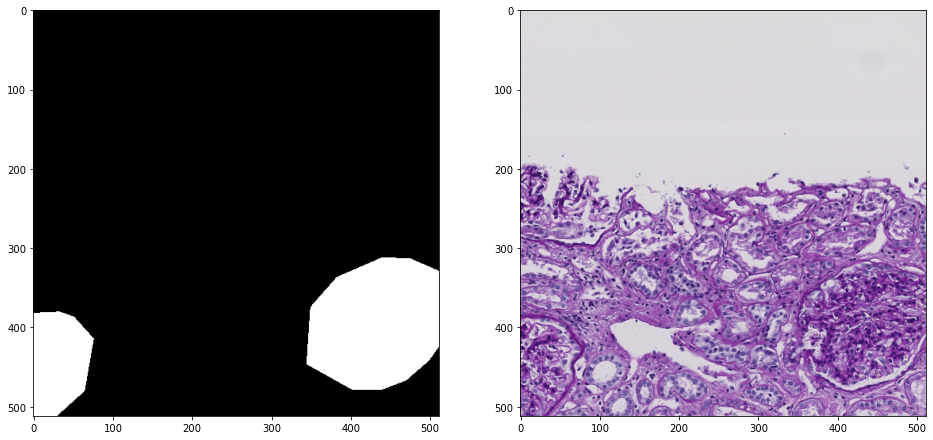

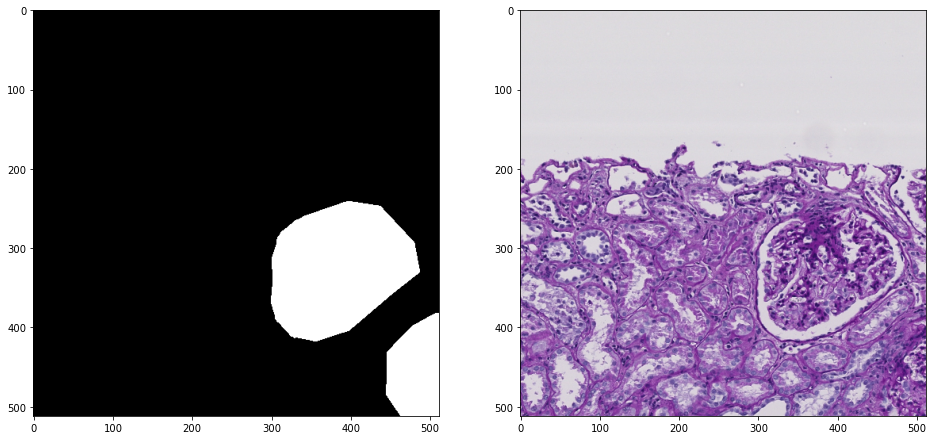

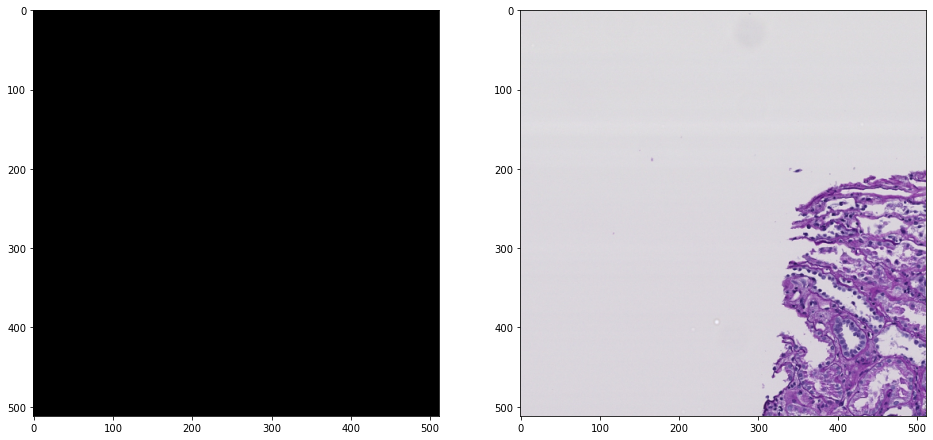

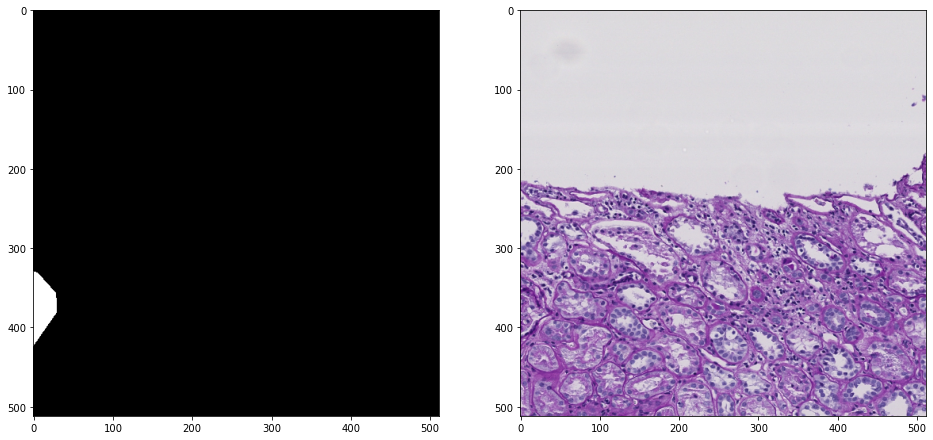

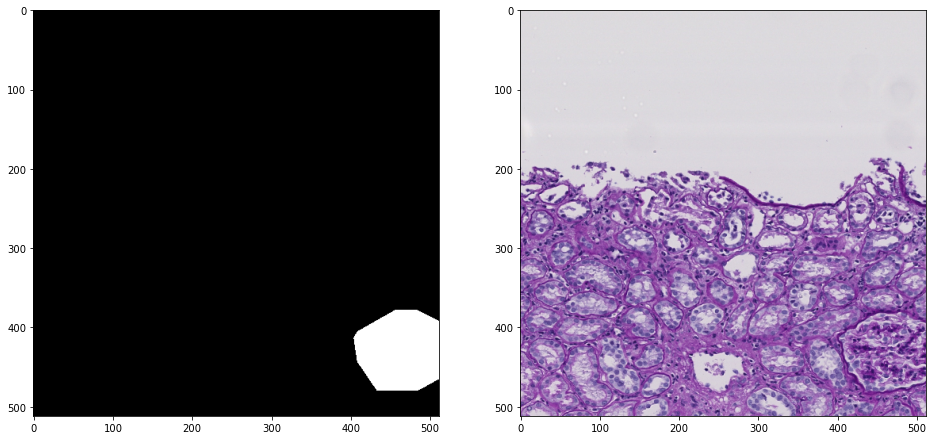

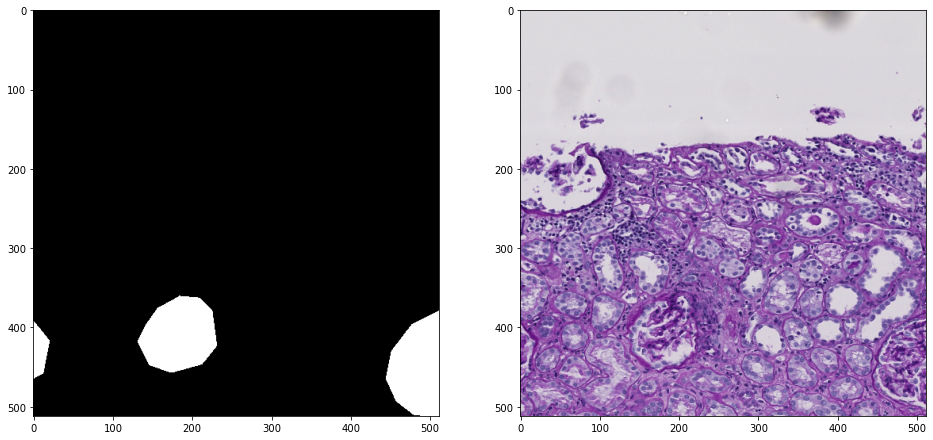

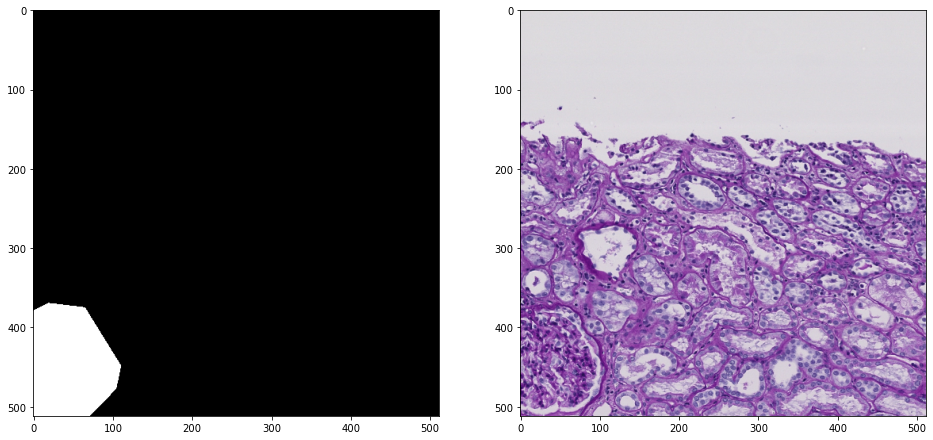

In [24]:
def display_mask_img(idx, ds):
    image, mask = ds[idx]
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.subplot(122)
    if image.shape[0] == 3:
        image = image.numpy()
        image = np.moveaxis(image, 0, -1)
    plt.imshow(image);

def display_samples(ds):
    display_mask_img(2, ds)
    display_mask_img(1, ds)
    display_mask_img(0, ds)
    display_mask_img(3, ds)
    display_mask_img(5, ds)
    display_mask_img(6, ds)
    display_mask_img(7, ds)
    
display_samples(ds)

In [25]:
ds = generate_ds()

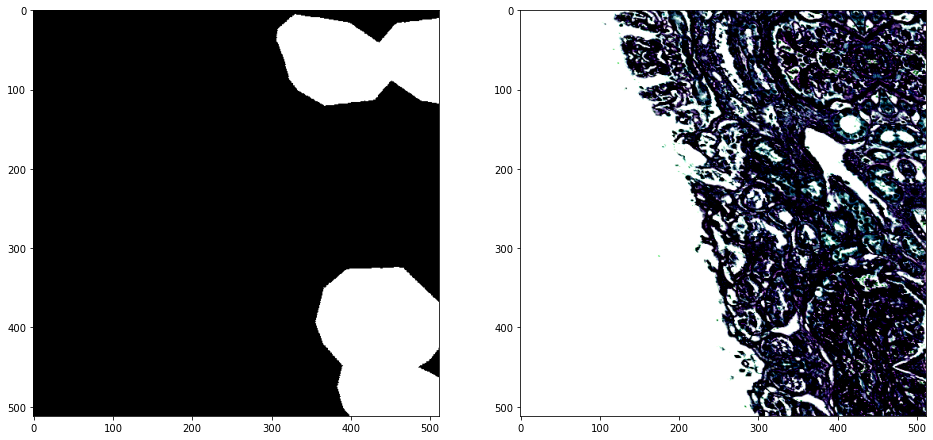

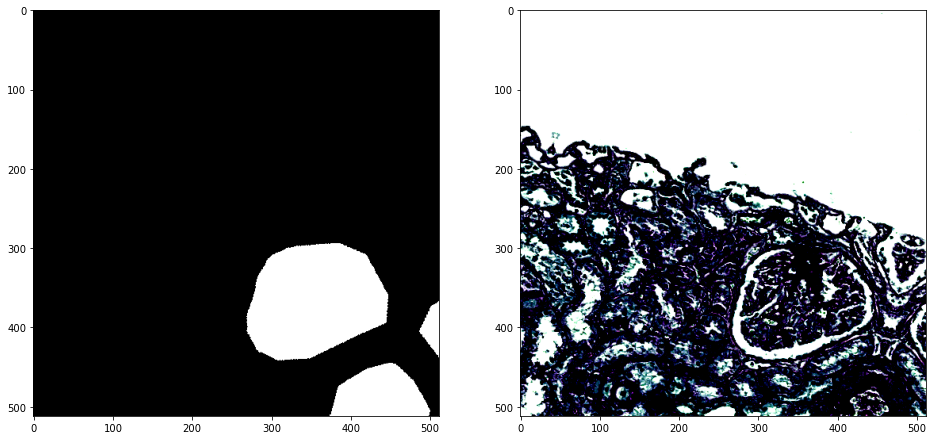

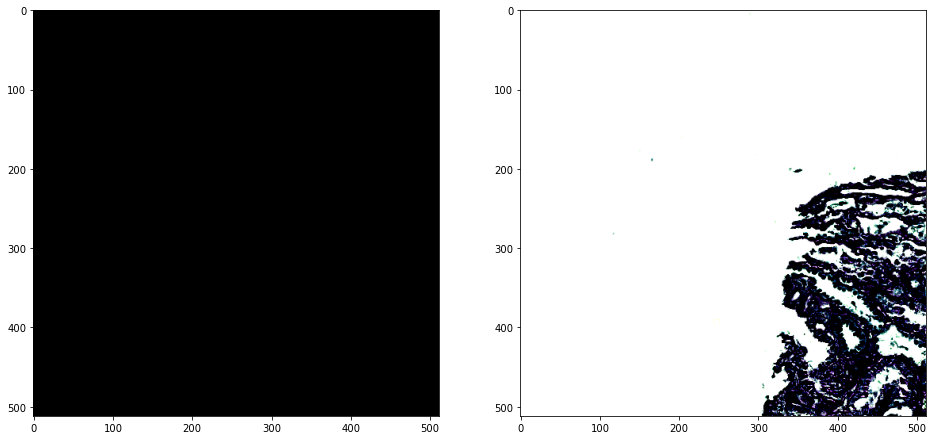

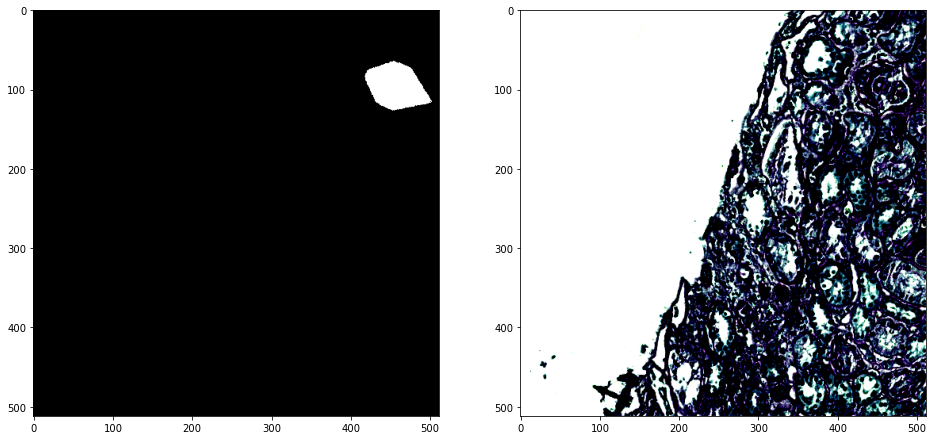

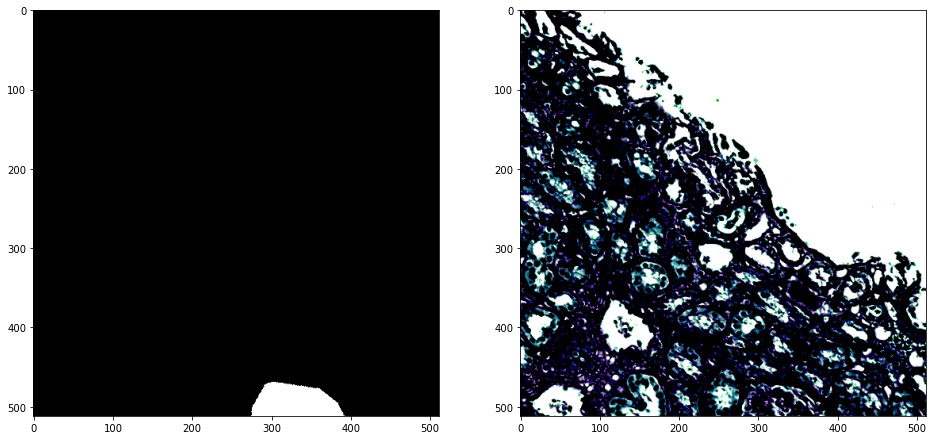

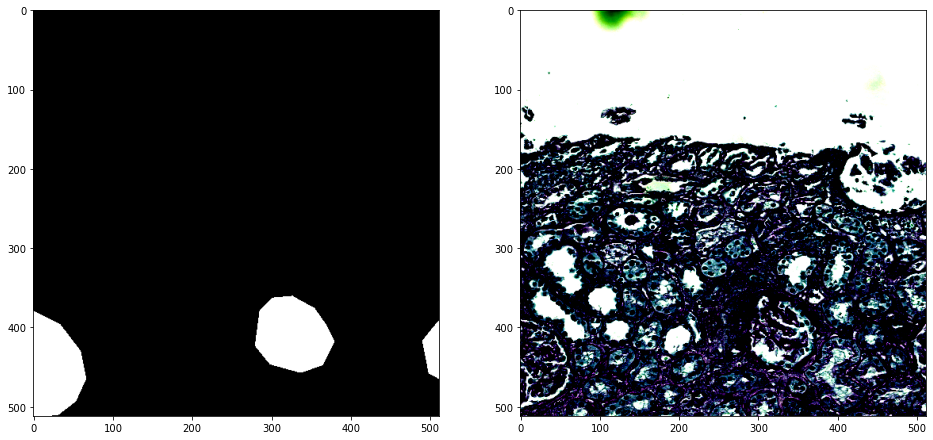

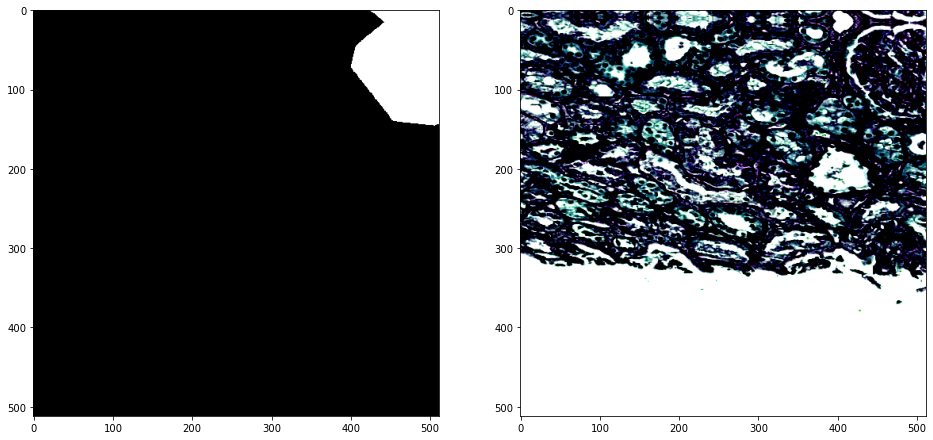

In [26]:
display_samples(ds)

### Folds

In [27]:
FOLDS = 4
BATCH_SIZE = 8

In [28]:
group_kfold = GroupKFold(n_splits = FOLDS)

In [29]:
fold_info = [(train_idx, valid_idx) for fold, (train_idx, valid_idx) in tqdm(enumerate(group_kfold.split(all_paths, 
                                                        groups = groups)), total=FOLDS)]

  0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
len(fold_info[0][0]), len(fold_info[0][1])

(5651, 1848)

In [31]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)

    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    return train_dl, valid_dl

In [32]:
sample_train_dl, sample_valid_dl = generate_train_valid_dls(ds, fold_info[0][0], fold_info[0][1])
sample_image, sample_mask = next(iter(sample_train_dl))
sample_image.shape, sample_mask.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 1, 512, 512]))

### Model

In [33]:
ENCODER_NAME = 'efficientnet-b6'

class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        self.model = UnetPlusPlus(encoder_name = ENCODER_NAME, 
                          encoder_weights = 'imagenet',
                          classes = 1,
                          activation = None)
        
        
    def forward(self, images):
        img_masks = self.model(images)
        return img_masks

In [34]:
def get_model():
    model = HuBMAPModel()
    return model

### Training

In [35]:
LR = 1e-3
WD = 1e-3
BEST_MODEL = f'best_model_unetplusplus_1024_png_gen_{ENCODER_NAME}.pth'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss + Metrics

In [37]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true, ce_ratio=0.8):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return ce_ratio * bce + (1 - ce_ratio) * dice

In [38]:
# dice_loss = smp.utils.losses.DiceLoss()

# def loss_fn(y_pred, y_true):
#     return dice_loss(y_pred.sigmoid(), y_true)

In [39]:
# jaccard_loss = smp.utils.losses.JaccardLoss()

# def loss_fn(y_pred, y_true):
#     return jaccard_loss(y_pred.sigmoid(), y_true)

In [40]:
def dice_metric(y_pred, y, epsilon = 1.0):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [41]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

### Training Methods

In [42]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu", grad_accu_steps=1):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    scale = None
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        
        with torch.cuda.amp.autocast():
            output = model(image)
            loss = criterion(output, target) / grad_accu_steps
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        if (step + 1) % grad_accu_steps == 0:
            scaler.step(optim)
            scale = scaler.get_scale()
            scaler.update()
            optim.zero_grad()
        
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        loss_val = loss.item() * grad_accu_steps
        train_loss.append(loss_val)
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss_val))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [43]:
def val_epoch(model, dataloader, criterion, epoch, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    dice_metrics = []
    iou_metrics = []

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
            dice_metrics.append(dice_metric(output, target))
            iou_metrics.append(iou_metric(output, target))
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metrics = [x.item() for x in dice_metrics]
    iou_metrics = [x.item() for x in iou_metrics]
    dice_metric_mean = np.array(dice_metrics).mean()
    iou_metric_mean = np.array(iou_metrics).mean()
    return dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean

In [44]:
def train(epochs, train_dl, valid_dl, optimizer, scheduler, patience = 6):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []
    early_stop_counter = 0

    for epoch in tqdm(range(epochs)):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, loss_fn, scheduler, DEVICE)
        dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean = val_epoch(model, valid_dl, loss_fn, epoch, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(np.array(dice_metrics).mean())
        if best_metric < iou_metric_mean:
            best_metric = iou_metric_mean
            print('Saving model')
            torch.save(model.state_dict(), BEST_MODEL)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}) iou metric ({iou_metric_mean}).')
        if early_stop_counter >= patience:
            print('Stopping early')
            break
        
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [45]:
EPOCHS = 8
PATIENCE = 5

In [46]:
def train_split(fold_info, fold):
    global model
    
    print(f'Processing fold {fold}')
    model = get_model()
    model.to(DEVICE)
    train_idx, valid_idx = fold_info[fold]
    f'Proportions valid / train: {len(valid_idx) / len(train_idx)}'
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(EPOCHS, train_dl, valid_dl, optimizer, scheduler, patience = PATIENCE)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [47]:
# train_idx, valid_idx = fold_info[0]
# train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
# for image, target in tqdm(train_dl):
#     pass
# #     assert image.shape[0] > 1
# for image, target in tqdm(valid_dl):
#     pass
# #     assert image.shape[0] > 1

In [48]:
def train_split_and_move(fold_info, fold):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(fold_info, fold)
    !mv {BEST_MODEL} {fold}_{BEST_MODEL}
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    val_stats_df = pd.DataFrame({'valid_losses': valid_losses})
    val_stats_df[['valid_losses']].plot()

Processing fold 0


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

Train loss: 0.36509378216475713
Epoch 0 - valid loss: 0.17304597985305828
Saving model
Epoch 0 - val best loss 0.17304597985305828 dice metric (0.757339337106907) iou metric (0.5913509520750699).


  0%|          | 0/707 [00:00<?, ?it/s]

Train loss: 0.14536899541764187
Epoch 1 - valid loss: 0.042568677670707385
Saving model
Epoch 1 - val best loss 0.042568677670707385 dice metric (0.9143811474630843) iou metric (0.7728072303442636).


  0%|          | 0/707 [00:00<?, ?it/s]

Train loss: 0.0787693830351892
Epoch 2 - valid loss: 0.034333399642302725
Saving model
Epoch 2 - val best loss 0.034333399642302725 dice metric (0.9273635502501484) iou metric (0.8266791147048108).


  0%|          | 0/707 [00:00<?, ?it/s]

Train loss: 0.057098670587301927
Epoch 3 - valid loss: 0.02870645607677762
Epoch 3 - val best loss 0.02870645607677762 dice metric (0.9321449682826087) iou metric (0.8059210087508963).


  0%|          | 0/707 [00:00<?, ?it/s]

Train loss: 0.05104321865114624
Epoch 4 - valid loss: 0.03202140409678565
Epoch 4 - val best loss 0.02870645607677762 dice metric (0.9289748862192229) iou metric (0.7994884873136433).


  0%|          | 0/707 [00:00<?, ?it/s]

Train loss: 0.04725120694289587
Epoch 5 - valid loss: 0.02888592148138698
Epoch 5 - val best loss 0.02870645607677762 dice metric (0.9305191837347947) iou metric (0.8244008819276207).


  0%|          | 0/707 [00:00<?, ?it/s]

Train loss: 0.04357426806420214
Epoch 6 - valid loss: 0.02610887499201465
Saving model
Epoch 6 - val best loss 0.02610887499201465 dice metric (0.9411985213622386) iou metric (0.8380470801636638).


  0%|          | 0/707 [00:00<?, ?it/s]

Train loss: 0.041349884713084414
Epoch 7 - valid loss: 0.027092203156011144
Saving model
Epoch 7 - val best loss 0.02610887499201465 dice metric (0.9395811077836272) iou metric (0.8488239099862303).


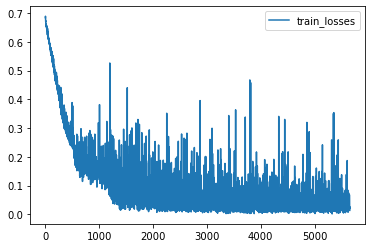

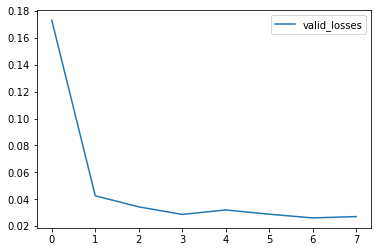

In [49]:
train_split_and_move(fold_info, 0)

In [ ]:
train_split_and_move(fold_info, 1)

Processing fold 1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

Train loss: 0.5011870679458535
Epoch 0 - valid loss: 0.18263514536348255
Saving model
Epoch 0 - val best loss 0.18263514536348255 dice metric (0.6009830385107886) iou metric (0.5958389064464026).


  0%|          | 0/718 [00:00<?, ?it/s]

Train loss: 0.15084681323208018


In [ ]:
train_split_and_move(fold_info, 2)

In [ ]:
train_split_and_move(fold_info, 3)

In [ ]:
!mv *.pth models